In [6]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="pcsk_4cAhnJ_JWTBdMu9iBKy1K1quPEj7kMqsG2qDCs7LXdYRMKELA3pDdjcD2akLVo5TNyprrM")

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model

conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(600, 600, 3))
input_image = Input(shape=( 600,600, 3))  # Input for the right branch
conv  = conv_base(input_image)  # Apply the same conv_base to the right branch
flaten = Flatten()(conv)
FC_layer = Dense(2048, activation='relu')(flaten)
Featur_vector = Dense(1024, activation='sigmoid')(FC_layer)
final_model = Model(inputs= input_image , outputs= Featur_vector)
final_model.compile(optimizer='adam', loss='categorical_crossentropy')

2025-01-15 20:36:27.576188: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 20:36:28.680995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-01-15 20:36:30.626266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-15 20:36:30.747640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-15 20:36:30.747990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

In [8]:
import pickle 
pickle.dump(final_model , open('Model.pkl','wb'))

2025-01-15 20:39:02.840649: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1358954496 exceeds 10% of free system memory.


In [2]:
import pickle 
final_model = pickle.load(open('/mnt/c/Users/YASH/OneDrive/Desktop/CBIR_System/CBIR_System/Model.pkl','rb'))

2025-01-15 20:45:29.508067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 20:45:31.015834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-01-15 20:45:44.586147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-15 20:45:44.963873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-15 20:45:44.964337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

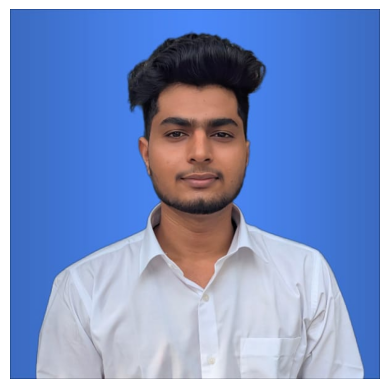

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

path = '/mnt/c/Users/YASH/OneDrive/Desktop/CBIR_System/CBIR_System/media/photos/photo.jpeg'
img = Image.open(path)  # Open the image
img = img.resize((600, 600))  # Resize the image
img_array = np.array(img)  # Convert to NumPy array
plt.imshow(img_array)  # Display the image
plt.axis('off')  # Hide axes
plt.show()


In [4]:
embedding = final_model.predict(img_array.reshape(1,600,600,3))

2025-01-15 20:46:15.732760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2025-01-15 20:46:15.981040: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-15 20:46:15.983808: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-15 20:46:15.983922: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2025-01-15 20:46:15.985459: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 2s 2s/step


2025-01-15 20:46:16.651280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [5]:
embedding.shape

(1, 1024)

In [75]:
full_name = "yash harishchandra karambe"
age = 22 
embedding_id = f"{full_name}_{age}"
embedding_id

'yash harishchandra karambe_22'

In [76]:
import pinecone
index_name = "image-similarity"  


pc = pinecone.Pinecone(api_key='pcsk_4cAhnJ_JWTBdMu9iBKy1K1quPEj7kMqsG2qDCs7LXdYRMKELA3pDdjcD2akLVo5TNyprrM')
# 
# Create index if it doesn't exist
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=512,  # Replace with your model dimensions
        metric="cosine",  # Replace with your model metric
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
    print(f"Index '{index_name}' created.")
else:
    print(f"Index '{index_name}' already exists.")

index = pc.Index(index_name)

Index 'image-similarity' created.


In [77]:
index = pc.Index(index_name)  # Connect to the created index

In [100]:
embedding_data = np.array(embedding, dtype=np.float32)
embedding_data = embedding_data.tolist()

In [ ]:
index.upsert(
    vectors=[
        {"id": embedding_id, "values": embedding_data[0]}
    ]
)

{'upserted_count': 1}

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

path = "/mnt/c/Users/YASH/OneDrive/Desktop/CBIR_System/CBIR_System/media/photos/DSC_0065.JPG"
img = Image.open(path)  # Open the image
img = img.resize((600, 600))  # Resize the image
img_array = np.array(img)  # Convert to NumPy array
plt.imshow(img_array)  # Display the image
plt.axis('off')  # Hide axes
plt.show()

In [95]:
query_vector = final_model.predict(img_array.reshape(1,600,600,3))

1/1 [==============================] - 0s 22ms/step


In [97]:
query_vector = np.array(query_vector, dtype=np.float32)
query_vector = query_vector.tolist()

In [ ]:
results = index.query(
    vector=query_vector,
    top_k=5,  # Number of results to retrieve
    include_metadata=False
)


In [99]:
results

{'matches': [{'id': 'yash harishchandra karambe_22',
              'score': 0.719740391,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 5}}

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

path = "/mnt/c/Users/YASH/OneDrive/Desktop/CBIR_System/Screenshot 2025-01-15 194706.png"
img = Image.open(path)  # Open the image
img = img.resize((600, 600))  # Resize the image
img_array = np.array(img)

plt.imshow(img_array)  # Display the image
plt.axis('off')  # Hide axes
plt.show()


In [5]:
img_array.shape

(600, 600, 4)

In [ ]:
img_array.reshape(1,600,600,3)